# Deep Learning Model 

In [1]:
# #!pip3 install opencv-python
# !pip install tensorflow
# !pip install sklearn
# !pip install seaborn
# !pip install matplotlib

In [330]:
# Libraries

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import random
import pickle

from PIL import Image
#!pip install mat73
import mat73
import helper

#import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping

%load_ext autoreload
%autoreload 2

### Parameters

In [3]:
resize = 0.2

## Image loading and preprocessing

In [4]:
### Load each file independently (to avoid memory overflows) and retriev PID
patient_ids_dict = dict()
label_ids_dict = dict()
shape_x_dict = dict()
shape_y_dict = dict()
image_dict = dict()
image_mask = dict()

for file_number in range(1,3047):
    file = f'../data/brain-tumor-data-public/{file_number}.mat'
    data_dict = mat73.loadmat(file)
    patient_ids_dict[file_number] = data_dict['cjdata']['PID']
    label_ids_dict[file_number] = int(data_dict['cjdata']['label'])
    shape_x_dict[file_number] = data_dict['cjdata']['image'].shape[0]
    shape_y_dict[file_number] = data_dict['cjdata']['image'].shape[1]
    image_dict[file_number] = data_dict['cjdata']['image']
    image_mask[file_number] = data_dict['cjdata']['tumorMask']

In [24]:
patient_ids = pd.Series(patient_ids_dict)
label_ids = pd.Series(label_ids_dict)
shape_x = pd.Series(shape_x_dict)
shape_y = pd.Series(shape_y_dict)
image = pd.Series(image_dict)
mask = pd.Series(image_mask)

patients = pd.DataFrame({'pid':patient_ids, 'label':label_ids,
                         'x':shape_x, 'y':shape_y, 'image':image, 'mask':mask}, index=range(1, 3047))

In [25]:
patients['image'] = patients['image'].apply(lambda x : helper.imx_preproc(x, zero_up_to_one=True, resize=resize))
patients['image'] = patients['image'].apply(lambda x : x.astype('float32'))

In [39]:
patients['mask'] = patients['mask'].apply(lambda x : helper.imx_preproc(x.astype('int16'), zero_up_to_one=True, resize=resize))
patients['mask'] = patients['mask'].apply(lambda x : x.astype('float32'))

## Train and Validation Sets

In [43]:
random.seed(1234)

val_size = 0.2
test_size = 0.2
# Training set has 2436 images test set has 610 images 
train_set, test_set = train_test_split(patients, stratify=patients['label'], test_size=test_size)
# Training set has 1948 images, validation set has 488 images
train_set, val_set = train_test_split(train_set, stratify=train_set['label'], test_size=val_size)

n_total_train = train_set.shape[0]

train_set_x = np.stack(train_set['image'].values)
train_set_y = np.stack(train_set['mask'].values)

val_set_x = np.stack(val_set['image'].values)
val_set_y = np.stack(val_set['mask'].values)

test_set_x = np.stack(test_set['image'].values)
test_set_y = np.stack(test_set['mask'].values)

We also add a 3 color channel representation of the image (by repeating the one channel we had 3 times). We do this to be able to use pretrained CNN that require us to provide inputs with that 3rd dimension. 

This is not the only way to proceed, but it should be good enough for our purposes and given that we can afford storing the data (because it is small in quantity and in image size).

https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a

In [42]:
train_set['image_3_channels'] = train_set['image'].apply(lambda x: np.expand_dims(x, axis = -1))
train_set['image_3_channels'] = train_set['image_3_channels'].apply(lambda x : x.repeat(3, axis = -1))

val_set['image_3_channels'] = val_set['image'].apply(lambda x: np.expand_dims(x, axis = -1))
val_set['image_3_channels'] = val_set['image_3_channels'].apply(lambda x : x.repeat(3, axis = -1))

#The following 2 lines result in warnings, but they work fine
test_set['image_3_channels'] = test_set['image'].apply(lambda x: np.expand_dims(x, axis = -1))
test_set['image_3_channels'] = test_set['image_3_channels'].apply(lambda x : x.repeat(3, axis = -1))

train_set_x_3_channels = np.stack(train_set['image_3_channels'].values)
val_set_x_3_channels = np.stack(val_set['image_3_channels'].values)
test_set_x_3_channels = np.stack(test_set['image_3_channels'].values)

<ipython-input-42-9c5926e387b6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['image_3_channels'] = test_set['image'].apply(lambda x: np.expand_dims(x, axis = -1))
<ipython-input-42-9c5926e387b6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['image_3_channels'] = test_set['image_3_channels'].apply(lambda x : x.repeat(3, axis = -1))


## CNN Implementation

In [44]:
batch_size = 64
IMG_H = int(round(512 * resize, 0))
IMG_W = int(round(512 * resize, 0))

optimizer = 'adam'

#### Build custom CNN

In [396]:
CNN = Sequential([
    InputLayer(input_shape=(IMG_H, IMG_W, 1)),
#     InputLayer(input_shape=(IMG_H, IMG_W, 3)), # For 3 channels
    
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(IMG_H * IMG_W, activation = 'relu'),
    
    tf.keras.layers.Reshape(target_shape=(IMG_H, IMG_W, 1)),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
])

CNN.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 100, 100, 64)      640       
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 11, 11, 64)     

In [422]:
# Compile: Define training parameters
CNN.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

# Train model
EPOCHS = 25
BATCHES = n_total_train//batch_size

### Following line overflows memory
fitted_model = CNN.fit(train_set_x, train_set_y, steps_per_epoch=BATCHES,
                       epochs=EPOCHS, validation_data=(val_set_x, val_set_y),
                      callbacks=[EarlyStopping(monitor='val_mse', patience=5)])

Epoch 1/25
30/30 [==============================] - 20s 644ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 2/25
30/30 [==============================] - 22s 738ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 3/25
30/30 [==============================] - 24s 786ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 4/25
30/30 [==============================] - 23s 779ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 5/25
30/30 [==============================] - 23s 771ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 6/25
30/30 [==============================] - 23s 775ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 7/25
30/30 [==============================] - 24s 786ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 8/25
30/30 [==============================] - 24s 792ms/step - 

### Results

In [424]:
model_id = 'mcv_3'

#### Summary

In [425]:
with open(f'../results/resize_{resize}_mask/{model_id}_summary.txt', 'w') as f:

    CNN.summary(print_fn=lambda x: f.write(x + '\n'))
    f.close()

#### Hyperparameters

In [426]:
with open(f"../results/resize_{resize}_mask/{model_id}_extended_summary.txt","w") as f:
    aux = CNN.get_config()
    aux['optimizer'] = optimizer
    aux['epoch'] = EPOCHS
    aux['batches'] = BATCHES
    f.write(str(aux))
    f.close()

#### Epoch convergence

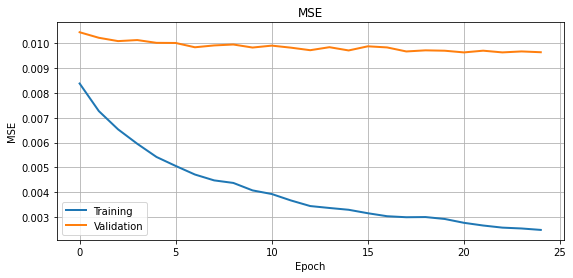

In [427]:
# Plot loss
plt.figure(figsize=(20, 4))

# plt.subplot(1, 2, 1)
# plt.title('Loss')
# plt.plot(CNN.history.history[''], label='Training', linewidth=2)
# plt.plot(CNN.history.history['val_loss'], label='Validation', linewidth=2)
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('MSE')
plt.plot(CNN.history.history['mse'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_mse'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)

plt.savefig(f'../results/resize_{resize}_mask/{model_id}_epochs.png', bbox_inches = 'tight')
plt.show()

#### Comparison with true mask

In [428]:
predictions = CNN.predict(test_set_x)

We round the predictions up to 0 or 1 given a threshold. This threshold is in a way a hyperparameter that has yet  to be studied more carefully, and was selected at the moment given that it showed mostly good results i.e. similar predicted masks to the true ones.

In [429]:
threshold = 0.2

predictions[predictions <= threshold] = 0
predictions[predictions > threshold] = 1

In [430]:
def preproc_masks(index):
    
    im = (255*test_set_x[index]).astype(np.uint8)  #np datatype for images
    im = Image.fromarray(im)

    true_mask = test_set['mask'].iloc[index].astype(np.uint8) #np datatype for images
    true_mask = Image.fromarray(true_mask)

    pred_mask = predictions[index].astype(np.uint8).reshape(IMG_H, IMG_W) #np datatype for images
    pred_mask = Image.fromarray(pred_mask)
    
    label = helper.translate_label(test_set['label'].iloc[index])
    
    return im, true_mask, pred_mask, label

In [431]:
def true_vs_predicted_mask(ax, label, title):

    [ax.spines[spine].set_visible(False) for spine in ax.spines]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title, fontsize = 14, y = 1.03)

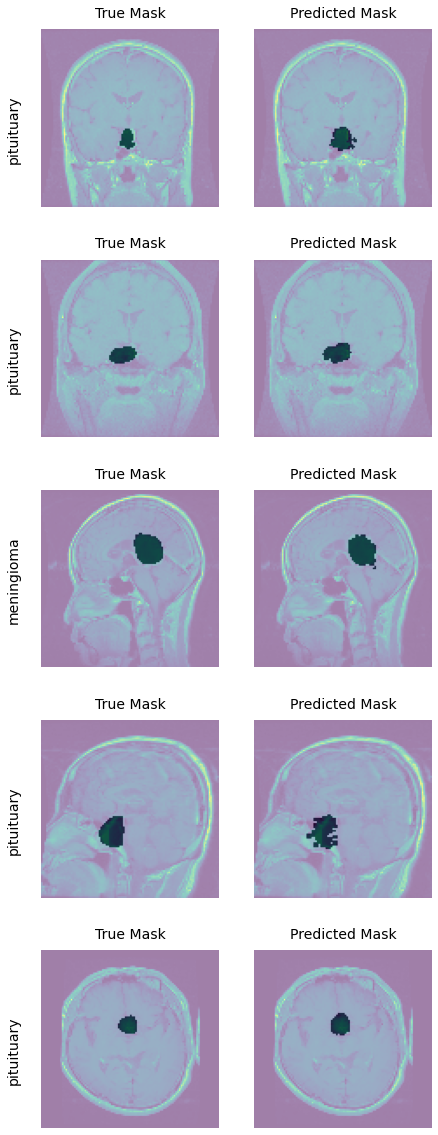

In [432]:
some_indexes = [random.randint(9, len(test_set)-1) for _ in range(5)]

fig, ax = plt.subplots(5, 2, figsize = (7,24))
plt.subplots_adjust(wspace=0.2, hspace=-.4)

for k, index in enumerate(some_indexes):    
    
    im, true_mask, pred_mask, label = preproc_masks(index)
    
    ax[k, 0].imshow(im)
    ax[k, 0].imshow(true_mask, cmap='Greys', alpha = 0.5)  
    true_vs_predicted_mask(ax[k, 0], label, 'True Mask')
    ax[k, 0].text(-20, 75, label,fontsize = 14, rotation=90)
    
    
    ax[k, 1].imshow(im)
    ax[k, 1].imshow(pred_mask, cmap='Greys', alpha = 0.5)
    true_vs_predicted_mask(ax[k, 1], label, 'Predicted Mask')
    
plt.savefig(f'../results/resize_{resize}_mask/{model_id}_true_Vs_pred1.png', bbox_inches = 'tight')

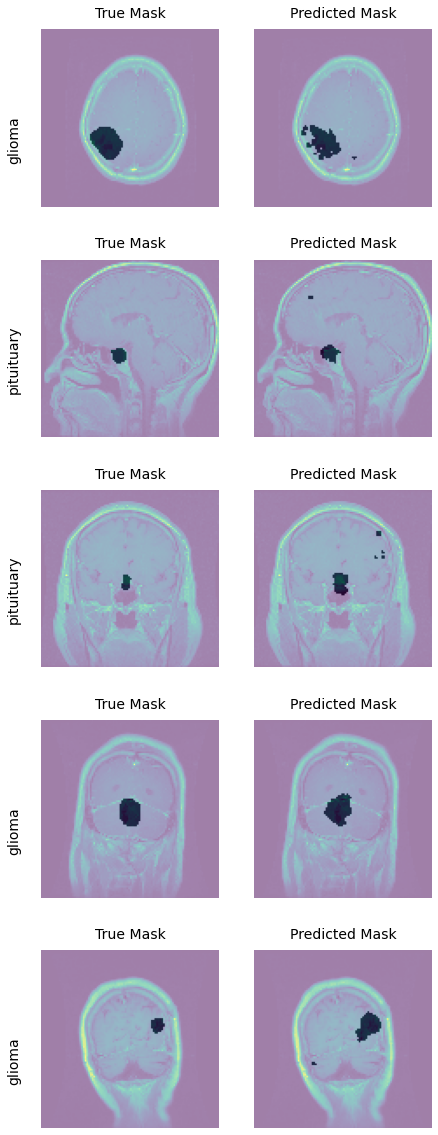

In [433]:
some_indexes = [random.randint(9, len(test_set)-1) for _ in range(5)]

fig, ax = plt.subplots(5, 2, figsize = (7,24))
plt.subplots_adjust(wspace=0.2, hspace=-.4)

for k, index in enumerate(some_indexes):    
    
    im, true_mask, pred_mask, label = preproc_masks(index)
    
    ax[k, 0].imshow(im)
    ax[k, 0].imshow(true_mask, cmap='Greys', alpha = 0.5)  
    true_vs_predicted_mask(ax[k, 0], label, 'True Mask')
    ax[k, 0].text(-20, 75, label,fontsize = 14, rotation=90)
    
    
    ax[k, 1].imshow(im)
    ax[k, 1].imshow(pred_mask, cmap='Greys', alpha = 0.5)
    true_vs_predicted_mask(ax[k, 1], label, 'Predicted Mask')
    
plt.savefig(f'../results/resize_{resize}_mask/{model_id}_true_Vs_pred2.png', bbox_inches = 'tight')

#### Performance

We have still not decided how to evaluate the performance. It could be the MSE between the predicted and the true masks, or the MSE between the _rounded_ predicted mask (by using the threshold) and the true mask. It could be both.

In [408]:
# f1 = f1_score(test_set_y, predictions, average='weighted')
# acc = accuracy_score(test_set_y, predictions)

# with open(f'../results/resize_{resize}_mask/{model_id}_performance.txt', 'w') as f:

#     performance = {'F1 score': round(f1,4), 'Accuracy': round(acc,4)}
    
#     f.write(str(performance))
#     f.close()

#### Pickle file

In [434]:
CNN.save(f'../results/resize_{resize}_mask/{model_id}_model.h5')